# Stochastic Simulation

*Winter Semester 2024/25*

31.01.2025

Prof. Sebastian Krumscheid<br>
Assistants: Stjepan Salatovic, Louise Kluge

<h3 align="center">
Exercise sheet 11
</h3>

---

<h1 align="center">
Markov Chains Monte Carlo
</h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm
from tqdm.notebook import tqdm
from typing import List, Tuple

In [2]:
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

## Exercise 1

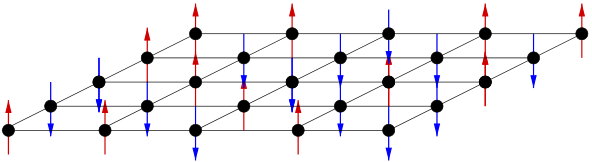

Let us consider a 2D uniform square-lattice with atoms placed at each
vertex, as is sketched in the Figure above.
The atoms can have an upward (red arrow) or a downward (blue
arrow) pointing magnetic moment (so-called _spin_). Specifically,
let the lattice be made out of $m \times m$ atoms. Therefore the
system's possible states are the $2^{m^2}$ possible spin choices for
the $m^2$ atoms.  That is, the spin of the atom at position
$(i,j)$ in the lattice is denoted with $s_{ij}$, $1\le i,j\le m$, and
can take a value in $\{-1,+1\}$. A specific system configuration is
described by the matrix
$\boldsymbol{S}=\left( s_{ij} \right)\in \{-1,+1\}^{m\times m}$,
containing the spin of each of the $m^2$ atoms.

The energy of a given system state of this Ising model is given by $$\tag{1} H(\boldsymbol{S}) = - \sum_{i,j=1}^{m} \left( \frac{1}{2} J s_{ij} (s_{i-1,j} + s_{i+1,j} + s_{i,j-1} + s_{i,j+1}) + Bs_{ij}\right)\;,$$
where $J$ is a magnetic coupling constant and $B$ is a constant
describing the external magnetic field. To account for boundary
effects, we set $s_{0,j}= s_{j,0} = s_{m+1,j} = s_{j,m+1} = 0$ for all $j \in \{1, \ldots, m\}$ in (1).
The probability of obtaining a specific system state is then given by the
_Boltzmann_ distribution with Probability Mass Function (PMF) $$\tag{2} f(\boldsymbol{S})\equiv f_\beta(\boldsymbol{S}) = \frac{1}{Z_\beta} e^{-H(\boldsymbol{S})\beta}\;,$$
where $\beta = 1/(k_B T)$ denotes the so-called inverse-temperature
(or thermodynamic beta) with $k_B$ being the Boltzmann constant and
$T$ the absolute temperature. Here, $Z_\beta$ denotes the
normalization constant that makes the target distribution
$f_\beta\colon \{-1,+1\}^{m\times m}\to \mathbb{R}_+$ a proper PMF.

Let's denote by $M(\boldsymbol{S}) =  \sum_{i,j=1}^{m} s_{ij}/m^2$
the system's average magnetic moment corresponding to the configuration
$\boldsymbol{S}$.
Notice that the random realizations of the
configuration matrix $\boldsymbol{S}$ depend on the inverse
temperature $\beta$. 
The expected value of the average magnetic moment $\overline{M}(\beta)$
as a function of the inverse temperature $\beta$ thus reads $$\tag{3}\overline{M}(\beta) %= \mathbb{E }\left[M(\boldsymbol{S}) \right]
= \sum_{\boldsymbol{S}\in \mathcal{K}} M(\boldsymbol{S}) f_\beta(\boldsymbol{S}) =  \frac{1}{Z_\beta} \sum_{\boldsymbol{S}\in \mathcal{K}} M(\boldsymbol{S}) e^{-H(\boldsymbol{S})\beta} \;,$$
where $\mathcal{K}=\{-1,1  \}^{m\times m}$ is the set of all possible system
configurations. Since the explicit computation of the normalization
constant $Z_\beta$ is computationally expensive (Explain why!), we
rely on the Metropolis–Hastings algorithm here. That is, at each step
a candidate configuration is proposed by randomly choosing an atom, with uniform
probability,  and  "flipping" its
spin.

1. Write a function that implements the Metropolis–Hastings
	algorithm for the Ising model. The input parameters for your
	function are: the number of steps $n$ of the chain that should be
	simulated, the number of atoms $m^2$, the inverse temperature
	$\beta$, the constants $J$ and $B$, and the initial state of the
	system. The function should return a list of energies and mean magnetic
	moments computed for each step of the chain, as well as the final
	configuration of the system.

Notice that the energy 
$$
  H(\boldsymbol{S}) = - \sum_{i,j=1}^{m} \left( \frac{1}{2} J s_{ij} (s_{i-1,j} + s_{i+1,j} + s_{i,j-1} + s_{i,j+1}) + B s_{ij}\right)\;,
$$
contains the products $s_{ij}s_{i-1,j},\dots$ twice, so that we can rewrite the energy as
\begin{equation*}
  H(\boldsymbol{S}) = - \sum_{i,j=1}^{m-1} J s_{ij} (s_{i+1,j} + s_{i,j+1}) - \sum_{i,j=1}^{m} B s_{ij}\;,
\end{equation*}
which is more amenable for an implementation (and, in fact, used
below). It is noteworthy however, that also the evaluation of the energy
in this rewritten form requires $\mathcal{O}(m^2)$ operations. That
is, if $m$ is large, the evaluation is computationally expensive!

However, in the Metropolis-Hastings algorithm, we only need to
evaluate the energy difference between two different states. In
particular, let us denote by $\boldsymbol{S}$ the current system
configuration at step $n$ of the algorithm and by $\boldsymbol{S}^c$
the proposed candidate configuration. Due to the particular proposal
structure, it follows that the only difference between
$\boldsymbol{S}$ and the candidate $\boldsymbol{S}^c$ is one
spin. Suppose that this difference is at the atom in position $(l,k)$,
so that
\begin{equation*}
\boldsymbol{S} = \left( s_{ij} \right), \ \ \ \ \boldsymbol{S}^c=\left( s_{ij}^c \right), \ \ \ \ \text{with} \ \ \ \ s_{ij}^c=\begin{cases}
s_{ij}\;, \ \ \ \ \ \ \text{if} \ \ \ \ i \neq l,\ j \neq k\;, \\ 
-s_{ij}\;, \ \ \ \ \text{if} \ \ \ \ i = l,\ j = k\;.
\end{cases}
\end{equation*}
Consequently, we can write the energy difference conveniently as
\begin{equation*}
\begin{split}
\Delta H(\mathbf{S}, \mathbf{S}^c) = H(\boldsymbol{S}^c) - H(\boldsymbol{S}) & = - J \left(s_{lk}^c - s_{lk} \right)
\left(s_{l-1,k} + s_{l+1,k} + s_{l,k-1} + s_{l,k+1} \right) - B \left( s_{lk}^c - s_{lk} \right) \\
& = 2 J s_{lk} (s_{l-1,k} + s_{l+1,k} + s_{l,k-1} + s_{l,k+1}) + 2B s_{lk}\;,
\end{split}
\end{equation*}  
which simplifies the implementation. Notice that the proposal transition matrix $Q(\mathbf{S}, \mathbf{S}^*)$ is symmetric. Indeed $Q(\mathbf{S}, \mathbf{S}^*) = Q(\mathbf{S}^*, \mathbf{S}) = \frac{1}{m^2}$ if $\mathbf{S}$ and $\mathbf{S}^*$ differ by only one spin and $Q(\mathbf{S}, \mathbf{S}^*) = 0$ if they differ by two or more spins. Hence the Metropolis-Hastings acceptance rate becomes 
\begin{equation}
\alpha(\mathbf{S}, \mathbf{S}^c) = \min\left\{1 , \frac{f(\mathbf{S}^c)Q(\mathbf{S}^c, \mathbf{S})}{f(\mathbf{S})Q(\mathbf{S},\mathbf{S}^c)} \right\} = \min\left\{1, \frac{f(\mathbf{S}^c)}{f(\mathbf{S})}\right\} = \min\left\{1, \exp\left[-\beta\Delta H(\mathbf{S}, \mathbf{S}^c)\right]\right\}.
\end{equation}  
A possible implementation that uses these formulas is shown below.
The Figures down below show the evolution of energy and magnetic moment as well as the state configuration for $\beta = 1/3$ and $\beta = 1$ respectively. 
For $\beta=1/3$, the configuration plot shows the formation of spin-up or spin-down clumps.
The expected total magnetic moment is expected to be zero, and we get an estimated value of $4.17$.
For $\beta = 1$, the configuration plot shows a phase transition, namely that the spins all align eventually in the same direction. 
The absolute value of the expected total magnetic moment of the invariant distribution is $2500$ in theory, and we get an estimated value of approximately $1968$ since we have not excluded any burn-in time from the calculation of the mean.
We use the ergodic estimator $$\overline{M}(\beta) \approx \frac{1}{n}\sum_{k=0}^n M(\mathbf{S}_k),$$
where $\mathbf{S}_k$ denotes the state at the $k^{\text{th}}$ step of the MH algorithm.

In [3]:
def H(S: np.array, J: float, B: float) -> float:
    """
    Computes the energy of a given system state `S` in the context of the Ising model.

    Args:
        S (np.array): The state of the system, represented as a 2D numpy array of spins, where each spin can be +1 or -1.
        J (float): The magnetic coupling constant between neighboring spins.
        B (float): The external magnetic field constant interacting with the spins.

    Returns:
        float: The total energy of the system state `S`.
    """
    return - J * ((S[:, :-1] * S[:, 1:]).sum() + (S[:-1, :] * S[1:, :]).sum() ) - B * S.sum()

The following cell verifies the correct implementation of your `H` function. If the `assert` statement passes without raising an error, it indicates that your function behaves as expected.

In [4]:
# CHECKPOINT
np.random.seed(999)
m = 50
random_state = np.random.choice([-1, 1], size=(m, m))

assert H(random_state, J=1, B=0.25) == 52

In [5]:
def ising(n: int, m: int, beta: float, J: float, B: float, S0: np.array) -> Tuple[np.array, np.array, np.array]:
    """
    Simulates the Ising model using the Metropolis algorithm over a square lattice.

    Args:
        n (int): The number of steps to perform.
        m (int): The size of the lattice (m x m).
        beta (float): The inverse temperature of the system (1/kT).
        J (float): The magnetic coupling constant between neighboring spins.
        B (float): The external magnetic field constant interacting with the spins.
        S0 (np.array): The initial state of the system, a 2D numpy array of spins (m x m).

    Returns:
        - E (np.array): The energy of the system at each step.
        - M (np.array): The magnetic moment of the system at each step.
        - S (np.array): The final state of the system.
    """
    # Allocate vectors derived from a system's state
    E = np.zeros(n+1)
    M = np.zeros(n+1)

    # Initialize system 
    S = S0

    # Magnetic moment and energy associated with the initial condition
    M[0] = S.sum()
    E[0] = H(S0, J, B)

    for k in range(n):
        
        # PROPOSAL : generate candidate state 
        Sc = S.copy()

        # select randomly an atom on the lattice
        i, j = np.random.randint(m, size=2)
        Sc[i,j] = - S[i,j] # flip the spin

        # Change in magnetic moment due to this flip 
        dM = - 2 * S[i,j]

        # Change in the energy due to this flip
        dE = 0
        if i > 0:
            dE = dE + S[i-1, j]
        if i < m-1:
            dE = dE + S[i+1, j]
        if j > 0:
            dE = dE + S[i, j-1]
        if j < m-1:
            dE = dE + S[i, j+1]
        dE = 2 * S[i, j] * (J * dE + B)

        # ACCEPT-REJECT STEP
        alpha = min(np.exp(-dE * beta), 1)
        U = np.random.random()
        if U < alpha:
            S = Sc # Accept proposed candidate state 
        else:
            dM = 0
            dE = 0

        # Update energy and magnetic moment 
        E[k+1] = E[k] + dE
        M[k+1] = M[k] + dM

    return E, M, S

2. Use your function with $\beta=1/3$ and for $n$, such that both the energy and the average magnetic moment appear to have reached stationarity. 
	Plot also the final system configuration.
	Furthermore, compute the mean magnetic moment $\overline{M}(\beta)$
	for different values of $\beta\in [\frac{1}{3},1]$ and
	$n=5\cdot 10^6$.  Choose a lattice of $50 \times 50$ atoms, $J=1$,
	and $B>0$, say $B = 10^{-1}$, for all simulations.

    **Hint:** For plotting a system state, have a look at the [`plt.spy()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.spy.html) function.

In [6]:
m = 50
J = 1.
B = 0.1
S0 = np.random.choice([-1, 1], size=(m, m))

n = int(1e6)

beta = 1 / 3
E, M, S = ising(n, m, beta, J, B, S0)

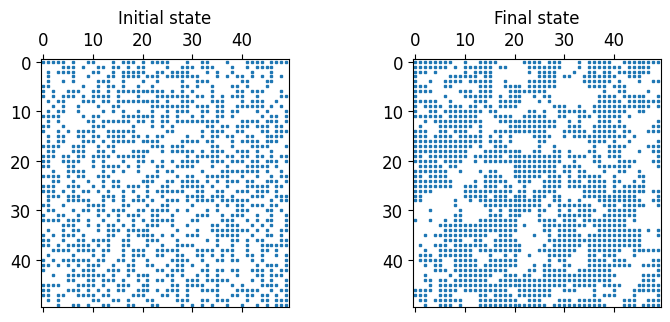

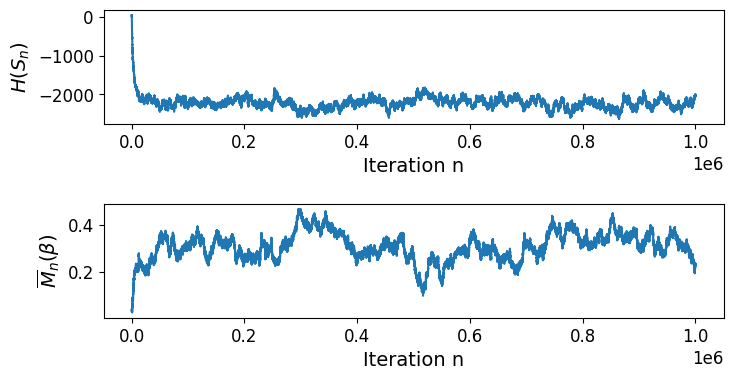

In [7]:
fig2 = plt.figure(figsize = (8,4))
ax1 = fig2.add_subplot(121)
ax1.spy(S0 + np.ones((m,m)), precision = 0.1, markersize = 2)
ax1.set_title('Initial state')
ax2 = fig2.add_subplot(122)
ax2.spy(S+np.ones((m,m)), precision = 0.1, markersize = 2)
ax2.set_title('Final state')
plt.subplots_adjust(wspace=0.5)


fig3 = plt.figure(figsize = (8,4))
ax3 = fig3.add_subplot(211)
ax3.plot(E)
ax3.set_xlabel('Iteration n')
ax3.set_ylabel('$H(S_n)$')
ax4 = fig3.add_subplot(212)
ax4.plot(M / m ** 2)
ax4.set_xlabel('Iteration n')
ax4.set_ylabel(r'$\overline{M}_n (\beta)$')
plt.subplots_adjust(hspace=0.7)

plt.show()

In [8]:
betas = np.linspace(0.1, 1.0, 10)
Ms = []

n = int(5e5)

B = 0.1
for b in tqdm(betas):
    E, M, S = ising(n, m, b, J, B, S0)
    meanM = M[int(2 / 3 * n):].mean() / m ** 2
    Ms.append(meanM)

  0%|          | 0/10 [00:00<?, ?it/s]

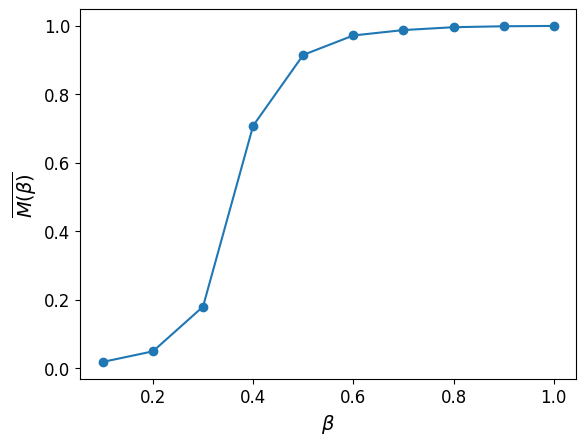

In [9]:
plt.plot(betas, np.abs(Ms), "o-")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\overline{M(\beta)}$")
plt.show()

## Exercise 2

Recall that the standard Metropolis–Hastings algorithm accepts a new candidate state $j$ drawn from the transition matrix $Q$, given the current state $i$, with probability $\alpha(i,j)=\min \left(\frac{\pi_j Q_{ji}}{\pi_i Q_{ij}},1\right)$, where $\pi$ is the target probability measure.
Consider now a Metropolis-Hastings algorithm that uses the follwing alternative acceptance probabilities $$\alpha_1(i,j)=\frac{\pi_j Q_{ji}}{\pi_jQ_{ji}+\pi_iQ_{ij}},$$ and $$\alpha_2(i,j)=\frac{\delta_{ij}}{\pi_i Q_{ij}},$$ with $\delta$ such that $\delta_{ij} \leq \pi_i Q_{ij} \forall i,j$. 
Show that, in both cases, the produced Markov chain satisfies the detailed balance condition.

Note that the detailed balance condition reads:
\begin{equation*}
\alpha(i,j)\pi_i Q_{ij} = \alpha(j,i) \pi_j Q_{ji}.
\end{equation*}
Consider the first case $\alpha_1(i,j) = \frac{\pi_jQ_{ji}}{\pi_j Q_{ji}+\pi_i Q_{ij}}$.
We then have that 
\begin{align*}
\alpha_1(i,j)\pi_i Q_{ij} = \frac{\pi_j Q_{ji}\pi_iQ_{ij}}{\pi_j Q_{ji}+\pi_i Q_{ij}} = \alpha_1(j,i)\pi_j Q_{ji}.
\end{align*}
Consider now the second case $\alpha_2(i, j) = \frac{\delta_{ij}}{\pi_i Q_{ij}}$ where $\delta_{ij} = \delta_{ji}$ is chosen such that $\alpha_2(i,j) \leq 1$, $\forall i, j$. Then
\begin{align*}
\alpha_2(i, j)  \pi_iQ_{ij} = \delta_{ij} = \delta_{ji} = \frac{\delta_{ji}}{\pi_jQ_{ji}} \pi_j Q_{ji} = \alpha_2(j, i) \pi_j Q_{ji}
\end{align*}

## Exercise 3 (Optional)
Consider the following AR(k) model defined by $$\mathbf{y}_n = A \mathbf{ y}_{n-1} +\mathbf{ \xi}_n, \quad \mathbf{ \xi}_n\overset{\text{iid}}{\sim} \mathcal{N}(0,\Gamma), \ \ \mathbf{ \xi}_n\in\mathbb{R}^k,$$ with $ A\in \mathbb{R}^{k\times k}$, invertible and $\Gamma\in \mathbb{R}^{k\times k} $ full rank.

1. Show that the previous process is a Markov chain.

Trivially, using the definition of the AR($k$) model and denoting $y_{[0,n]} = (y_0, y_1, \dots, y_n)$, we have that 
\begin{eqnarray*}
\mathbb{P}(\mathbf{ y}_n \leq \mathbf{ y} | \mathbf{ y}_{[0, n-1]}) & = & \mathbb{P} (\boldsymbol{\xi}_n \leq \mathbf{ y} - A\mathbf{ y}_{n-1} | \mathbf{ y}_{[0, n-1]}) = \mathbb{P} (\boldsymbol{\xi}_n \leq \mathbf{ y} - A \mathbf{ y}_{n-1} | \mathbf{ y}_{n-1}) \\ & = & \mathbb{P} (\mathbf{ y}_n \leq \mathbf{ y} | \mathbf{ y}_{n-1}), 
\end{eqnarray*}
since $\mathbb{P} (\boldsymbol{\xi}_n \leq \mathbf{ y} - A \mathbf{ y}_{n-1} | \mathbf{ y}_{n-1}) $ is the Gaussian $\mathcal{N}(0, \Gamma)$ cummulative distribution function evaluated at $\mathbf{ y} - A \mathbf{ y}_{n-1} $.

2. Show that if $\mathbf{ y}_0 \sim \mathcal{N}(0,\Gamma_0)$, then $\mathbf{y}_n$ follows  a multivariate Gaussian distribution for all $n$. 

We can show that the characteristic function for $\mathbf{ y}_1$ is 
\begin{equation}
\mathbb{E}[e^{i\mathbf{ t}' \mathbf{ y}_1}] = \mathbb{E}[e^{i \mathbf{ t}' A \mathbf{ y}_0}] \mathbb{E}[e^{i \mathbf{ t}' \boldsymbol{\xi}_1}] = e^{-\frac{1}{2}\mathbf{ t}' A \Gamma_0 A' \mathbf{ t}} e^{-\frac{1}{2}\mathbf{ t}' \Gamma \mathbf{ t}} = e^{-\frac{1}{2}\mathbf{ t}' (A\Gamma_0 A' + \Gamma) \mathbf{ t}}
\end{equation}
that is the c.f. function of a Gaussian with zero mean and covariance $A \Gamma_0 A' + \Gamma$. Using induction and repeating the same argument one can easily show that for arbitrary $n$ the covariance is of $\mathbf{ y}_n$ is $ A^n \Gamma_0 \left(A^{n} \right)' + \sum_{i=0}^{n-1} A^i \Gamma \left(A^{i}\right)'$.

3. Find the invariant distribution of an AR(1) process (i.e., a special case of the previous model). 

For $k= 1$ we have $y_n = ay_{n-1}+ \xi_n$, $\xi_n \sim N(0, \gamma)$. Assume that $y_{n-1} \sim N(0, \sigma^2)$, then $y_n \sim N(0, a^2\sigma^2 + \gamma)$. Hence $N(0, \sigma^2)$ is invariant iff $\sigma^2 = a^2\sigma^2 + \gamma$ which implies $\sigma^2 = \frac{\gamma}{1-a^2}$ and $|a| < 1$.

4. Simulate the AR(1) process with $a = 0.8, \gamma = 0.2, \gamma_0 = 2$ and assess its convergence to the invariant distribution. In addition, verify the ergodic theorem on the quantity  $$\hat \mu^N=\frac{1}{N}\sum_{n=1}^{N}y_n.$$ 

In [10]:
def AR_1(a: float, gamma: float, gamma0: float, n: int, n_samples: int) -> np.array:
    """
    Generates samples from an autoregressive process of order 1 (AR(1)).

    Args:
        a (float): The autoregressive coefficient.
        gamma (float): The variance of the innovation process.
        gamma0 (float): The variance of the initial observation.
        n (int): The number of time steps in the AR(1) process.
        n_samples (int): The number of independent AR(1) processes to simulate.

    Returns:
        np.array: A two-dimensional numpy array where each row represents one AR(1) process,
                  and each column represents a time step.
    """
    y0 = np.sqrt(gamma0) * np.random.randn(n_samples)
    xi = np.sqrt(gamma) * np.random.randn(n_samples, n)
    y = a ** n * y0 + (a ** np.arange(n) * xi).cumsum(axis=1).T
    return y.T

The empirical invariant distribution of AR(1) follows after simulating a large number of "paths" (here $10^4$) and plotting the histogram and a large $n = 10^4$. Resulting distribution is shown in the Figure down below for $a = 0.8$, $\gamma_0 = 2$, $\gamma = 0.2$.

In [11]:
a = 0.8
gamma = 0.2
gamma0 = 2.0
n_samples = 10000
n = 100

In [12]:
y = AR_1(a, gamma, gamma0, n, n_samples)

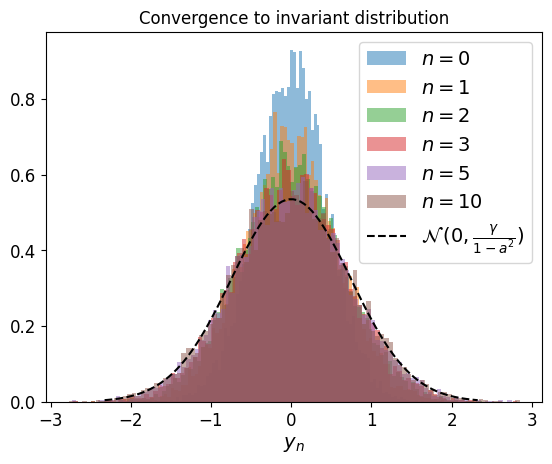

In [13]:
ns = [0, 1, 2, 3, 5, 10]
for n_ in ns:
    plt.hist(y[:, n_], label=f"$n = {n_}$", bins=100, density=True, alpha=0.5)

invariant_dist = norm(0, np.sqrt(gamma / (1 - a ** 2)))
x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
plt.plot(x, invariant_dist.pdf(x), "k--", label=r"$\mathcal{N}\,(0, \frac{\gamma}{1 - a^2})$")
plt.legend()
plt.title("Convergence to invariant distribution")
plt.xlabel("$y_n$");

5. Establish theoretically the convergence of $\hat \mu ^N$ by using the strong law of large numbers, and a weighted version of the central limit theorem (e.g. Lindeberg-Feller).

For the almost surely convergence we write 
\begin{eqnarray}
\hat{\mu}^N & = & \frac{1}{N}\sum_{n=1}^N y_n = \frac{1}{N}\sum_{n=1}^N \left( a^n y_0 + \sum_{i=1}^n a^{n-i}\xi_i \right) \\ & = & y_0 \frac{1}{N}\sum_{n=1}^N a^n + \frac{1}{N}\sum_{n=1}^{N} \sum_{i=1}^n a^{n-i} \xi_i \\  & = & y_0 \frac{1}{N}\sum_{n=1}^N a^n + \frac{1}{N}\sum_{i=1}^{N} \sum_{n=i}^{N} a^{n-i} \xi_i \\ & = & y_0 \frac{1}{N}\sum_{n=1}^N a^n + \frac{1}{N}\sum_{i=1}^{N} \frac{1 - a^{N-i}}{1 - a} \xi_i \\ & = & y_0 \frac{1}{N}\sum_{n=1}^N a^n + \frac{1}{1-a}\frac{1}{N}\sum_{n=1}^N \xi_i - \frac{a}{(1-a)N}\sum_{i=1}^N a^{N-i} \xi_i,
\end{eqnarray}
where by the SLLN, the first term on the right hand side $A_N := y_0 \frac{1}{N}\sum_{n=1}^N a^n \to 0$ a.s., the second term $B_N := \frac{1}{1-a}\frac{1}{N}\sum_{i=1}^N \xi_i \to 0$ a.s.. For the third term $C_N := \frac{a}{(1-a)N}\sum_{i=1}^N a^{N-i} \xi_i$ we have 
\begin{equation}
\mathbb{V}\left(C_N\right) = \frac{a^2}{(1-a)^2 N^2}\sum_{i=0}^{N-1} a^{2i} \Gamma \leq \frac{a^2}{(1 - a)^2(1-a^2)}\frac{\Gamma}{N^2}
\end{equation}
and $\mathbb{E}[C_N] = 0$, hence 
\begin{equation}
\mathbb{P}\left(|C_N| < \epsilon \right) \leq \frac{\mathbb{V}(C_N)}{\epsilon^2} \leq \frac{k(\epsilon)}{N^2}
\end{equation}
with $k(\epsilon) = \frac{a^2\Gamma}{\epsilon^2(1 - a)^2(1- a^2)}$ and $\sum_{N=1}^{\infty} \mathbb{P}\left(|C_N| > \epsilon\right) \leq \sum_{N=1}^{\infty} \frac{k(\epsilon)}{N^2} < +\infty$. So by the Borel-Cantelli lemma $C_N \to 0$ a.s.

For the CLT, we can use the Lindeberg-Feller theorem for triangular arrays: \\
For each $N$ let $X_{N,m}$, $1 \leq m \leq N$ be independent random variables such that 

- $\mathbb{E}[X_{N,m}] = 0$
- $\sum_{m=1}^N \mathbb{E}[X_{N,m}^2] \to \sigma^2 < \infty$
- For all $\epsilon > 0$, $\lim_{N\to\infty} \sum_{m=1}^N \mathbb{E}[ |X_{N,m}|^2 ; |X_{N,m}| > \epsilon]$ = 0.

Then $\sum_{m=1}^N X_{N,m} \to N(0, \sigma^2)$ in distribution. We apply the theorem with $X_{N,m} = \frac{1}{\sqrt{N}}\frac{1 - a^{N -m + 1}}{1 - a}\xi_m$. Then
1. $\quad\sum_{m=1}^N \mathbb{E}[X_{N,m}^2] = \sum_{m=1}^N \frac{1}{N}\frac{1 - a^{N-m+1}}{1- a}\gamma \to \frac{\gamma}{1 - a}$, and
2. \begin{eqnarray*}
\sum_{m=1}^N \mathbb{E}\left[X_{N,m}^2 \big\vert |X_{N,m}| > \epsilon\right] & = & \sum_{m=1}^N \mathbb{E}\left[ \frac{(1 - a^{N-m+1})}{(1-a)^2N} \epsilon_m^2 \big\vert |\xi_m| > \epsilon\sqrt{N}(1-a)/(1 -a^{N-m+1})\right] \\ &\leq & \sum_{m=1}^N\frac{1}{(1 - a)^2N} \mathbb{E}\left[ \xi_m^2 \big\vert |\xi_m| > \epsilon\sqrt{N}(1 - a) \right] \\ & =&  \frac{1}{(1-a)^2}\mathbb{E}\left[ \xi_1^2 \big\vert |\xi_1| > \epsilon \sqrt{N}(1-a)\right] \to 0.
\end{eqnarray*}
Hence $\sum_{m=1}^N X_{N,m} = \sqrt{N}\left( \frac{1}{N} \sum_{i=1}^N \frac{1 - a^{N-i+1}}{1-a}\xi_i \right) \to N(0, \frac{\gamma}{1-a})$ and $\sqrt{N}\hat{\mu}^N \to N(0, \frac{\gamma}{1-a})$. Notice that $\frac{\gamma}{1-a} > \mathbb{V}[y_{\infty}]$, i.e. the estimator $\hat{\mu}^N$ is less efficient (has a larger variance) than a Monte Carlo estimator $\tilde{\mu}^N = \frac{1}{N}\sum_{n=1}^N y_n$ where $y_n$ are iid $N(0, \frac{\gamma}{1-a^2})$.